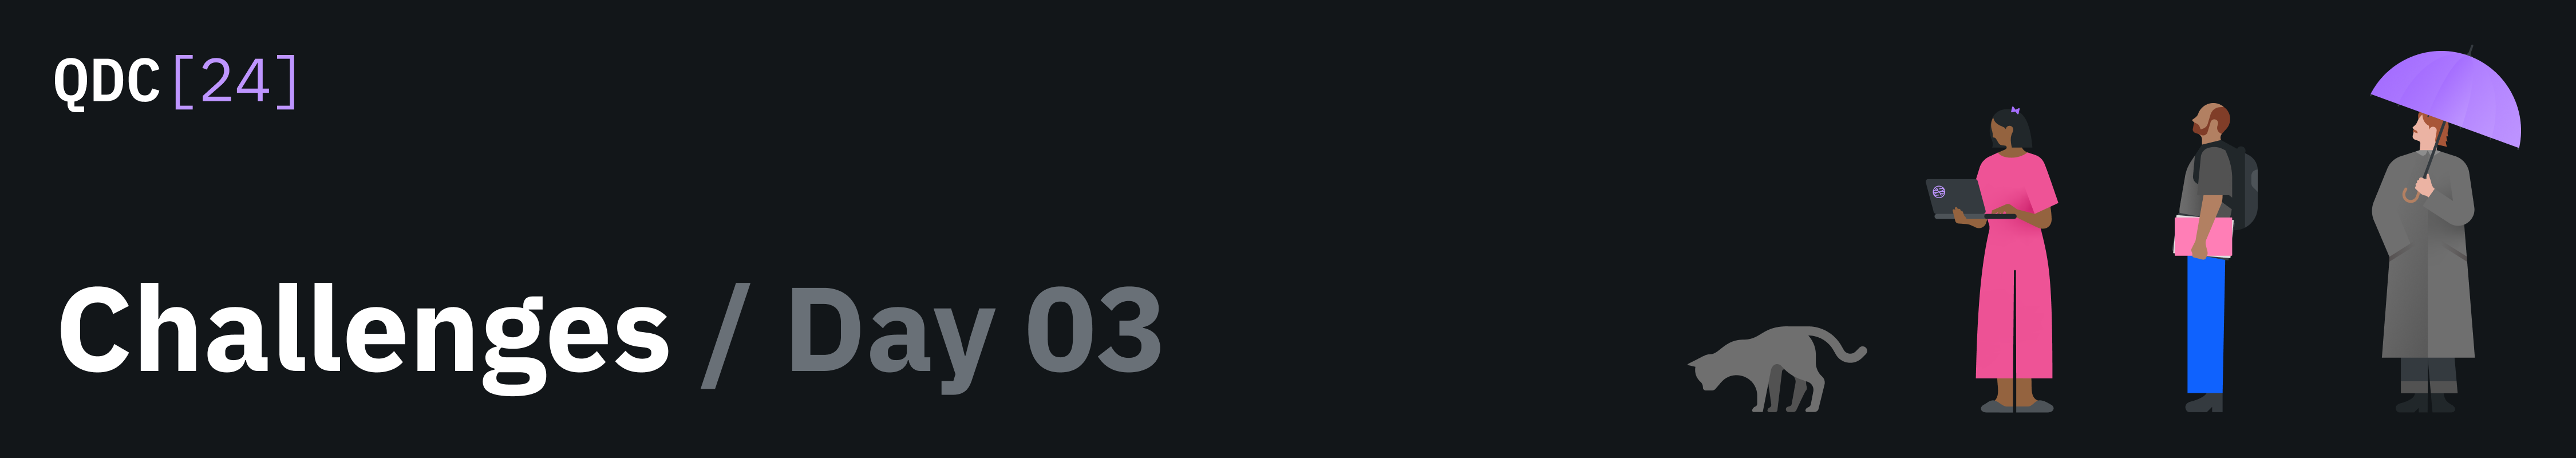

# QDC Day 1 - Challenge Track B: Accuracy and Execution

In this challenge we will use precalculated data from noise learning to do error mitigation (using zero-noise extrapolation (ZNE)) in order to improve the results of a utility-scale quantum circuit.

The purpose of this challenge is to give you hands-on experience experimenting with different options to get the best possible result. We will use precalculated data from the noise learning because it speeds up the ZNE significantly.

The challenge itself is simple: get the best possible results; however, getting there is not easy, and you will need to play around with different settings to improve your results. 

[You can find the notebook for Track A here](https://github.com/qiskit-community/qdc-challenges-2024/tree/main/Day_3/QDC_Day_3_Track_A.ipynb).

## Documentation Quick Reference 



|  Tool with link  |  Description  |
|---|---|
|[Noise Learner](https://docs.quantum.ibm.com/guides/noise-learning)|Learning noise for a specific circuit using observables|
|[Error mitigation options](https://docs.quantum.ibm.com/guides/runtime-options-overview)|Examples and explanation of error mitigation options in Qiskit Runtime|
|[IBM Quantum Account](https://docs.quantum.ibm.com/guides/setup-channel)|How to set up your account|
|[Zero Noise Extrapolation (ZNE) Options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions)|Available options for ZNE in order to fine-tune error mitigation|
|[Probabilistic Error Amplification](https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques#probabilistic-error-amplification-pea)|ZNE method that uses noise learning to get better results|
|[Twirling Options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions)|Options used for twirling|

### Installing the required components


You will most likely have this already installed, but in case you are starting from a fresh Python environment, run the cell below (only do so if you need to install the tools).

Also make sure that the qiskit-ibm-runtime version you have is the newest, as it includes everything you nead.

In [ ]:
# In case this is not yet installed

# %pip install qiskit[visualization]>=1.0
# %pip install qiskit-ibm-runtime>=0.31
# %pip install qiskit-aer
# %pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

### Importing libraries


We import here all the libraries we will need in the notebook.

In [ ]:
import numpy as np
import random
random.seed(10)

from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorOptions
import json
from qiskit_ibm_runtime.utils import RuntimeEncoder, RuntimeDecoder
from utils_Track_B import get_circuit

In [ ]:
# Import grader
from qc_grader.challenges.qdc_2024_2 import (
    submit_day3b_ex1,
    submit_name,
    grade_day3b_ex1,
    submit_feedback_3b_1,
    submit_feedback_3b_2,
    submit_feedback_3b_3
)

Save your IBM Quantum account:

In [ ]:
### Save API Token, if needed
 
# # Save an IBM Quantum account and set it as your default account.
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="Your_Token",
#     set_as_default=True,
#     # Use `overwrite=True` if you're updating your token.
#     overwrite=True,
# )

In [ ]:
# Choose the right instance
instance = 'events/qdc-day-3b/team-n'

service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
backend = service.backend("ibm_cusco")
#backend = service.backend("ibm_strasbourg")

In this challenge, you will try to get the best expectation values using a given quantum circuit.

To improve your results, you are expected to use error mitigation techniques like ZNE.

We will use an implementation of a quantum circuit from the following reference: 

**Reference**: Y. Kim et al. *Evidence for the utility of quantum computing before fault tolerance.* [Nature 618.7965 (2023)](https://www.nature.com/articles/s41586-023-06096-3)


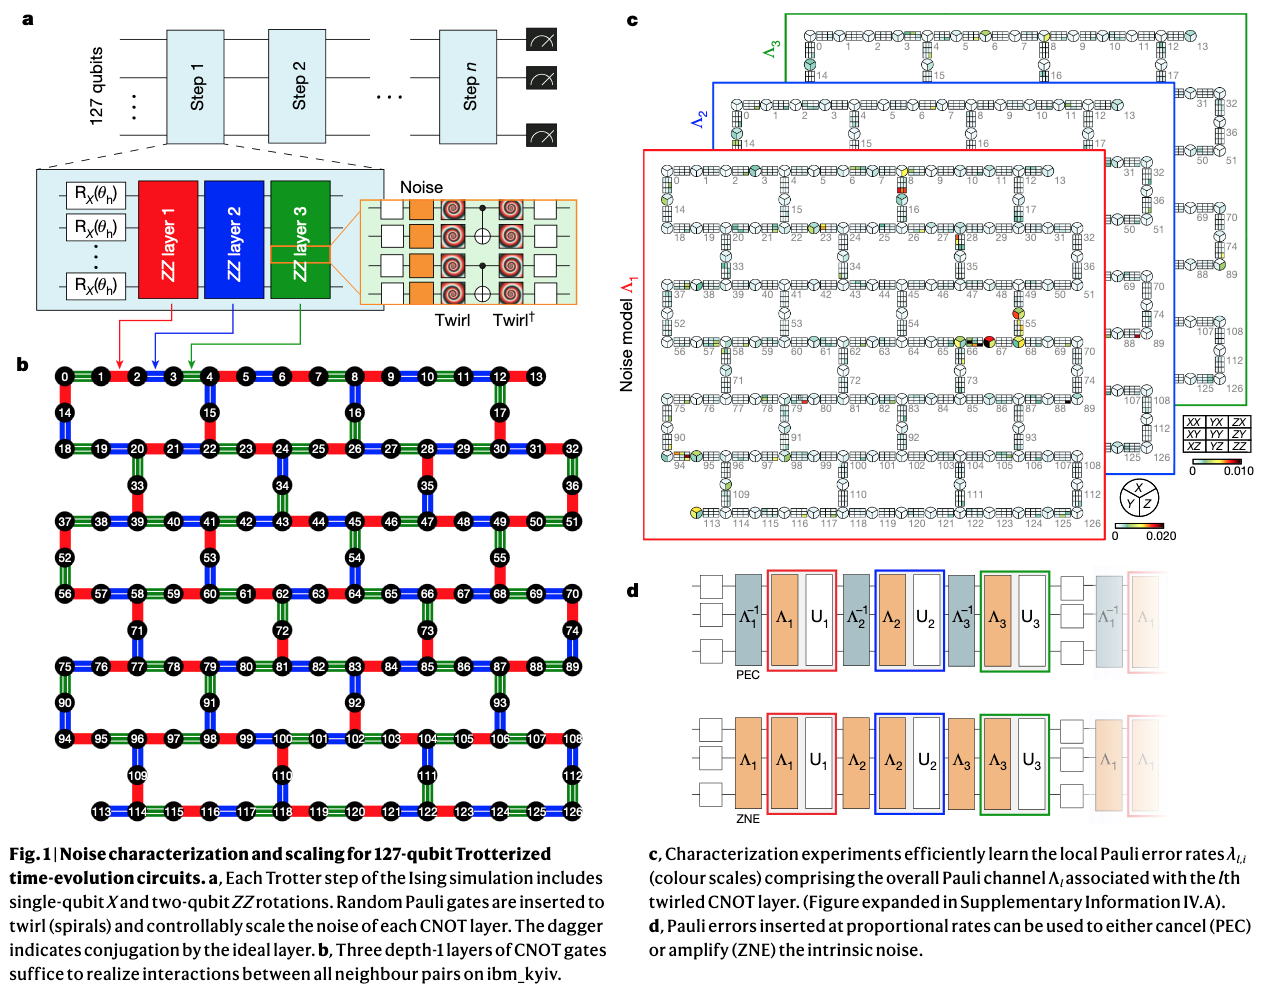


We advise you to use ZNE with PEA to improve the results, as it was done in the linked paper. 


You can implement ZNE with the following steps:

1. Amplify circuit noise for several noise factors $\lambda_1, \lambda_2, ... $
2. Run every noise-amplified circuit to measure $\langle A(\lambda_1)\rangle, ...$
3. Extrapolate back to the zero-noise limit $\langle A(0)\rangle$


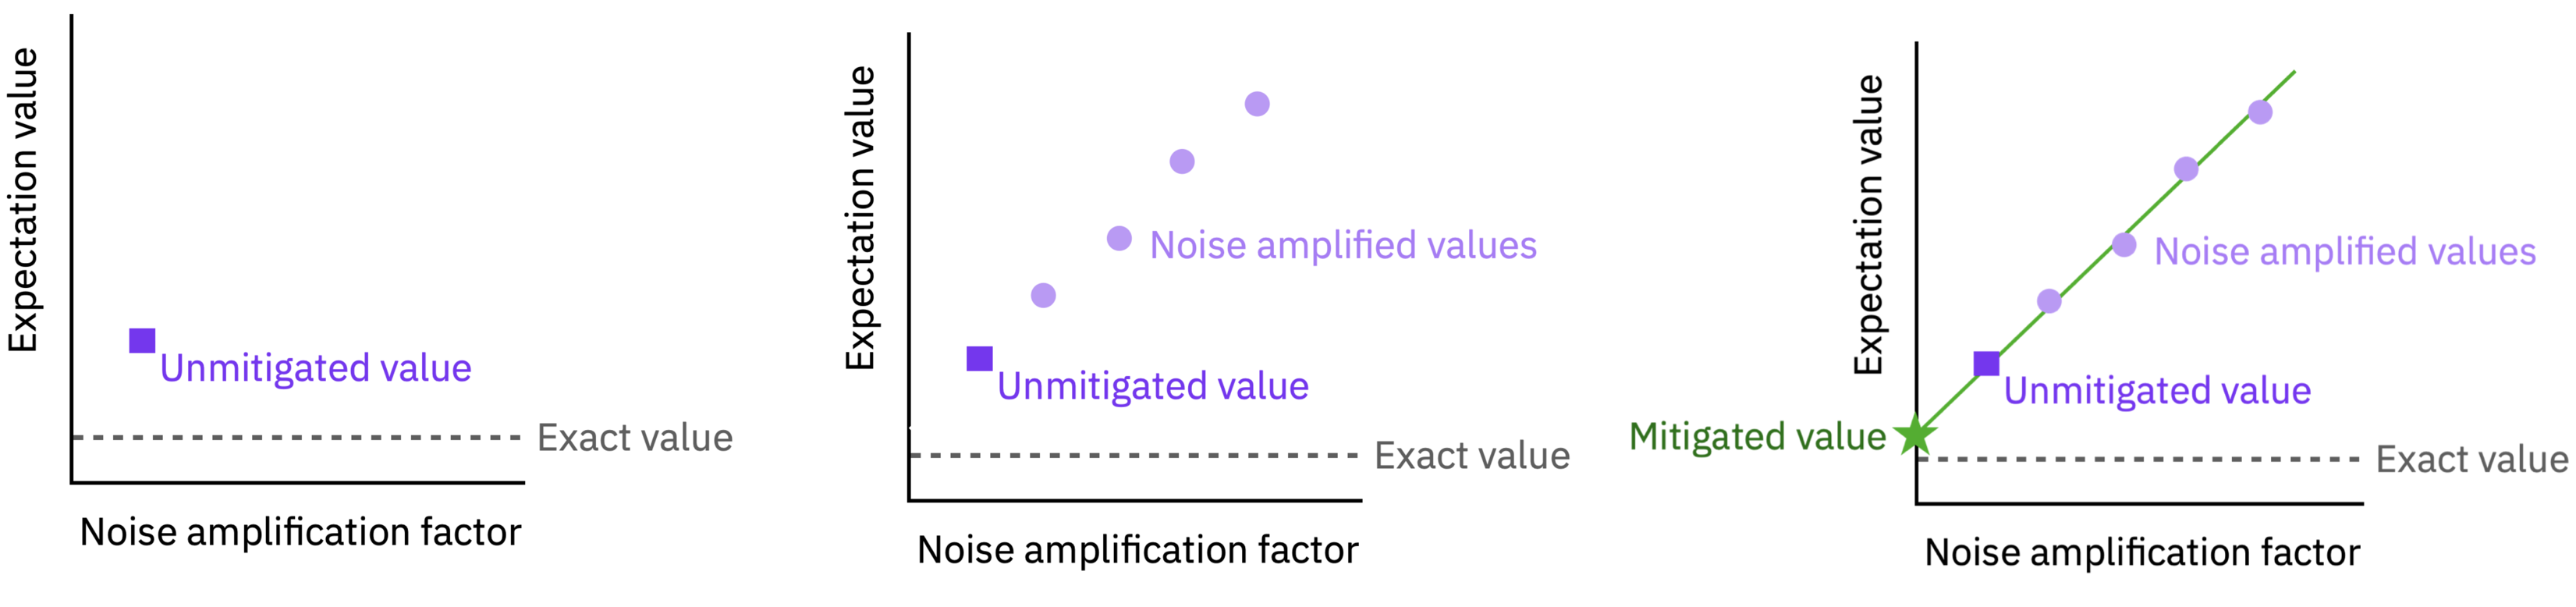



For example, you can amplify the noise using gate folding or probabilistic error amplification. For utility-scale experiments, the latter is the most attractive, especially if you have already learned the noise with the NoiseLearner tool. For this exercise, you will have access to different noise models obtained with different [NoiseLearner options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.NoiseLearnerOptions).


You don't have to implement the circuit yourself. 
We implemented the utility circuit for you, which you can get with the following line of code:

In [ ]:
# qc is the transpiled parameterized quantum circuit
# observables are the single Z for all the qubits
# parameter_values is defined as np.linspace(0, np.pi / 2, num_params).reshape((num_params, 1))
# pub is (qc,observables,parameter_values[0])
pub, qc, observables, parameter_values = get_circuit(backend)

### The NoiseLearner

Learning the noise model of a quantum circuit is important both because it helps in measuring progress towards more performant QPUs, and because when noise models are known, they can be mitigated.

Qiskit’s [NoiseLearner](https://docs.quantum.ibm.com/guides/noise-learning) program implements an efficient and scalable protocol to provide information about the noise model of the layers. With the learned noise model, you can use, for example, ZNE with probabilistic error amplification (PEA).

We calculated the noise learning for you beforehand, to save time. For the [NoiseLearnerOptions](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.NoiseLearnerOptions) we used `layer_pair_depths`='(0, 1, 2, 4, 16, 32)' and all possible `twirling_strategy` options. 


<div class="alert alert-danger alert-info">
    <strong> Please do not try to run your own noise learning - it would take too much time. 
</div>


Of course, if you wish, you can try to learn the noise model in your own time at home.

We can load the prelearned noise models from the provided files using the following code:

In [ ]:
backend = 'ibm_cusco'
# You can load 4 different noise models with different twirling strategies changhing the last number in the file name:
# f"NoiseModels/{backend}_noise_model_1.json"
# f"NoiseModels/{backend}_noise_model_2.json"
# f"NoiseModels/{backend}_noise_model_3.json"
# f"NoiseModels/{backend}_noise_model_4.json"
with open(f"NoiseModels/{backend}_noise_model_1.json", "r") as file:
    encoded_from_file = file.read()
decoded = json.loads(encoded_from_file, cls=RuntimeDecoder)
noise_model = decoded['data']

<div class="alert alert-block alert-info">
<strong> Feedback Question:</strong><br>
Had you heard about the NoiseLearner tool before this challenge?
</div>


In [ ]:
# Any feedback is appreciated!

feedback =
submit_feedback_3b_1(feedback)

<div class="alert alert-block alert-info">
<strong> Feedback Question:</strong><br>
Do you envision using the NoiseLearner in the future? If so, please expand on how you plan to incorporate it into your workflow. If not, please share why you do not believe you will use it.
</div>

In [ ]:
# Any feedback is appreciated!

feedback =
submit_feedback_3b_2(feedback)

<div class="alert alert-block alert-warning">

🏆 **Scored Challenge** 

This is a scored challenge, and your submission results will count toward the leaderboard!

Good luck, take your time to experiment, and enjoy the challenge!
</div>

Now that you have both the circuit and the results from the Noise Learner, you can get to work:


<a id="exercise_Exploratory"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1: Use error mitigation to get a good result for the given circuit.</b> 

Use the prelearned noise model from the device to run the circuit given below with ZNE and PEA. As you try to get the best possible result, note that the difference between the ideal result and mitigated result is you are looking for. 
</div> 



Now it's time for you to experiment and find good settings.

You can use the following cell to provide your solution:

In [ ]:
options = EstimatorOptions()  
# Adapt the options
options.resilience.zne_mitigation = True
options.resilience.layer_noise_model = noise_model
options.resilience.zne.amplifier = "pea"
options.resilience.zne.noise_factors = # add here
options.resilience.zne.extrapolator = # add here
# Write your code here for additional options

<div class="alert alert-block alert-warning">
    
⚠️ **Please note** 

Before submitting jobs, make sure you check the options, and that they make sense. Try to discuss what options could lead to good results instead of guessing randomly.
</div>




We prepared the pub above in a way that the expectation values should all be 1.

Therefore, the closer your values are to 1, the better your results!

#### Check the parameters before submitting the job

In [ ]:
# Run your job in real hardware using the following code:

job_for_grading = submit_day3b_ex1(options, pub)
# To print the error in case the submission was not successful
if type(job_for_grading) == str:
    print(job_for_grading)

In [ ]:
# Check job status
print(job_for_grading.status())

#### Submit your result

In [ ]:
# Please choose your username for the leaderboard

username = 
submit_name(username)

In [ ]:
# Submit your answer using the following code:

grade_day3b_ex1(job_for_grading)

The result of your submission shows the error rate. The lower it is the better.

<div class="alert alert-block alert-info">
<strong> Feedback Question:</strong><br>
Do you use advanced error mitigation options? Why or why not?
</div>

In [ ]:
# Any feedback is appreciated!

feedback =
submit_feedback_3b_3(feedback)

## Thank You for Participating!

Congratulations on completing **Day 3 of the Quantum Developer Challenge (QDC)**! 

We hope you enjoyed experimenting with error mitigation for a utility-scale circuit. We know it's not an easy task, but it is an important part of running real circuits, and now you have experienced first-hand the effects of the new `NoiseLearner`. As you can see, the stored `NoiseLearnerResult` allows you to speed up subsequent error mitigation tries on the same circuit by a huge factor. 

Feel free to refer back to this notebook, check out the [Track A notebook](https://github.com/qiskit-community/qdc-challenges-2024/tree/main/Day_3/QDC_Day_3_Track_A.ipynb), revisit exercises, and try some of the optional sections to refine your skills. We hope this journey has inspired you to push the boundaries of quantum computing!


We hope you enjoyed these last three days and learned from the talks as well as the challenges. 

See you next year!

# Additional information

**Created by:** Simone Cantori, Marcel Pfaffhauser

**Advised by:** Junye Huang, Sam Ferracin, Jessie Yu

**Version:** 1.0.0